<a href="https://colab.research.google.com/github/Hemashree2003/voice-to-image-ai/blob/main/final_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install required libraries
!pip install transformers torch torchaudio librosa

In [3]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import ffmpeg
from scipy.io.wavfile import read as wav_read
import io

# This is a more robust function for recording audio in Colab
def record_audio(filename='audio.wav'):
  """
  Records audio from the microphone in Colab and returns the file path.
  """
  # JavaScript to display a start/stop button and record audio
  js = Javascript("""
    async function recordAudio() {
      const div = document.createElement('div');
      const startButton = document.createElement('button');
      startButton.textContent = 'Start Recording';
      div.appendChild(startButton);

      const stopButton = document.createElement('button');
      stopButton.textContent = 'Stop Recording';
      stopButton.disabled = true;
      div.appendChild(stopButton);

      const audio = document.createElement('audio');
      audio.controls = true;
      div.appendChild(audio);

      document.body.appendChild(div);

      const stream = await navigator.mediaDevices.getUserMedia({audio: true});
      let recorder = new MediaRecorder(stream);
      let chunks = [];

      startButton.onclick = e => {
        recorder.start();
        startButton.disabled = true;
        stopButton.disabled = false;
        startButton.textContent = 'Recording...';
      }

      stopButton.onclick = e => {
        recorder.stop();
        startButton.disabled = false;
        stopButton.disabled = true;
        startButton.textContent = 'Start Recording';
      }

      recorder.ondataavailable = e => chunks.push(e.data);

      // Return a promise that resolves with the audio data
      return new Promise(resolve => {
        recorder.onstop = e => {
          const blob = new Blob(chunks, { 'type' : 'audio/ogg; codecs=opus' });
          audio.src = URL.createObjectURL(blob);
          const reader = new FileReader();
          reader.onloadend = () => resolve(reader.result);
          reader.readAsDataURL(blob);
        }
      });
    }
    """)

  # Display the UI and start the recording process
  print("Please use the buttons below to record your audio.")
  display(js)

  # eval_js will now wait for the promise to resolve
  data = eval_js('recordAudio()')

  # Decode the base64 data
  binary = b64decode(data.split(',')[1])

  # Use ffmpeg to convert the audio to a standard WAV format
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  # Save the final audio to a file
  with open(filename, 'wb') as f:
    f.write(output)

  return filename

# ===============================================================
#  Main pipeline code (now using our new recording function)
# ===============================================================
from transformers import pipeline

# 1. Load the pre-trained Speech-to-Text model
speech_recognizer = pipeline("automatic-speech-recognition", model="openai/whisper-base.en")

# 2. Record audio live using the interactive buttons
audio_file_path = record_audio()
print(f"Recording saved to {audio_file_path}")

# 3. Transcribe the recorded audio
print("Transcribing audio...")
transcription = speech_recognizer(audio_file_path)
prompt_text = transcription['text']

print("\n--- TRANSCRIPTION COMPLETE ---")
print(f"Detected Text: {prompt_text}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cuda:0


Please use the buttons below to record your audio.


<IPython.core.display.Javascript object>

`return_token_timestamps` is deprecated for WhisperFeatureExtractor and will be removed in Transformers v5. Use `return_attention_mask` instead, as the number of frames can be inferred from it.
Using custom `forced_decoder_ids` from the (generation) config. This is deprecated in favor of the `task` and `language` flags/config options.


Recording saved to audio.wav
Transcribing audio...

--- TRANSCRIPTION COMPLETE ---
Detected Text:  Raining in the village.


In [4]:
!pip install ffmpeg-python


In [5]:
# Install libraries for image generation
!pip install diffusers accelerate

Loading the Stable Diffusion model...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Model loaded successfully onto the GPU.

Generating image for prompt: ' Raining in the village.'


  0%|          | 0/50 [00:00<?, ?it/s]

Image generation complete!
Displaying the generated image:


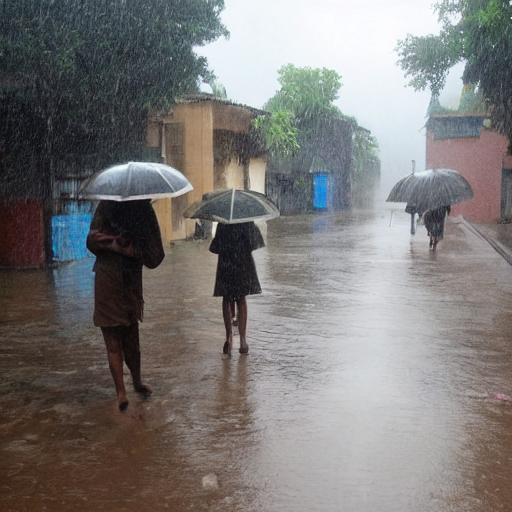


Image saved as 'generated_image.png' in the Colab environment.


In [6]:
from diffusers import StableDiffusionPipeline
import torch

# 1. Load the pre-trained Text-to-Image model
# This will download several gigabytes of model data the first time you run it.
# It's a good idea to run this only once per session.
print("Loading the Stable Diffusion model...")
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)

# 2. Move the model to the GPU for fast performance
# This is why we enabled the T4 GPU in the runtime settings.
pipe = pipe.to("cuda")
print("Model loaded successfully onto the GPU.")

# 3. Generate the image using the text from our audio
# This uses the 'prompt_text' variable from the previous cell.
print(f"\nGenerating image for prompt: '{prompt_text}'")
# This step can take 30-60 seconds to run.
image = pipe(prompt_text).images[0]
print("Image generation complete!")

# 4. Display and save the image
print("Displaying the generated image:")
display(image)

image.save("generated_image.png")
print("\nImage saved as 'generated_image.png' in the Colab environment.")

In [7]:
# 1. Install the library for the user interface
!pip install gradio soundfile -q

# 2. Import all necessary libraries
import gradio as gr
import torch
from transformers import pipeline
from diffusers import StableDiffusionPipeline
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import ffmpeg
import soundfile as sf

# 3. Load the AI Models (Do this once to save time)
print("Loading Speech-to-Text model...")
speech_recognizer = pipeline("automatic-speech-recognition", model="openai/whisper-base.en")
print("Speech-to-Text model loaded.")

print("Loading Text-to-Image model...")
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")
print("Text-to-Image model loaded.")

# 4. Re-use our robust audio recording function
def record_audio(filename='audio.wav'):
  js = Javascript("""
    async function recordAudio() {
      const div = document.createElement('div');
      const startButton = document.createElement('button');
      startButton.textContent = 'Start Recording';
      div.appendChild(startButton);

      const stopButton = document.createElement('button');
      stopButton.textContent = 'Stop Recording';
      stopButton.disabled = true;
      div.appendChild(stopButton);

      const audio = document.createElement('audio');
      audio.controls = true;
      div.appendChild(audio);

      document.body.appendChild(div);

      const stream = await navigator.mediaDevices.getUserMedia({audio: true});
      let recorder = new MediaRecorder(stream);
      let chunks = [];

      startButton.onclick = e => {
        recorder.start();
        startButton.disabled = true;
        stopButton.disabled = false;
        startButton.textContent = 'Recording...';
      }

      stopButton.onclick = e => {
        recorder.stop();
        startButton.disabled = false;
        stopButton.disabled = true;
        startButton.textContent = 'Start Recording';
      }

      recorder.ondataavailable = e => chunks.push(e.data);

      return new Promise(resolve => {
        recorder.onstop = e => {
          const blob = new Blob(chunks, { 'type' : 'audio/ogg; codecs=opus' });
          audio.src = URL.createObjectURL(blob);
          const reader = new FileReader();
          reader.onloadend = () => resolve(reader.result);
          reader.readAsDataURL(blob);
        }
      });
    }
    """)

  display(js)
  data = eval_js('recordAudio()')
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  with open(filename, 'wb') as f:
    f.write(output)

  return filename


# 5. Define the master function that connects everything
def speak_to_image_app():
    # Step A: Record audio using our function
    print("Waiting for audio recording...")
    audio_path = record_audio()
    print(f"Audio recorded and saved to {audio_path}")

    # Step B: Transcribe audio to get the text prompt
    print("Transcribing audio...")
    transcription = speech_recognizer(audio_path)
    prompt = transcription['text']
    print(f"Prompt: '{prompt}'")

    # Step C: Generate an image from the text prompt
    print("Generating image...")
    image = pipe(prompt).images[0]
    print("Image generated.")

    # Step D: Return the final results
    return image, prompt

# This line is a placeholder; we will launch the app in the next step.
print("\nApp function is ready. Launch the interface in the next cell.")

Loading Speech-to-Text model...


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cuda:0


Speech-to-Text model loaded.
Loading Text-to-Image model...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Text-to-Image model loaded.

App function is ready. Launch the interface in the next cell.


In [ ]:
# 6. Create and Launch the Gradio Web App
gr.Interface(
    fn=speak_to_image_app,
    inputs=None, # No direct input widget, the function handles it
    outputs=[
        gr.Image(label="Generated Image"),
        gr.Textbox(label="Transcribed Prompt")
    ],
    title="🔊 Voice-to-Image AI 🖼️",
    description="A final-year project demonstrating a full speech-to-vision pipeline. Click 'Submit' to start the recording process."
).launch(debug=True, share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://a0e99c12c581f58cd9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Waiting for audio recording...


<IPython.core.display.Javascript object>

Audio recorded and saved to audio.wav
Transcribing audio...
Prompt: ' Bloom it.'
Generating image...


  0%|          | 0/50 [00:00<?, ?it/s]

Image generated.
Waiting for audio recording...


<IPython.core.display.Javascript object>

Audio recorded and saved to audio.wav
Transcribing audio...
Prompt: ' Women standing in the heavy rain with the umbrella with the sad face.'
Generating image...


  0%|          | 0/50 [00:00<?, ?it/s]

Image generated.
